In [11]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [12]:
import os
import sys

try:
    import google.colab  # Check if running in Google Colab
    IN_COLAB = True

except ImportError:
    IN_COLAB = False

if IN_COLAB:
    repo_name = 'conn4-rl'
    %cd /content
    if os.path.exists(repo_name):
        %cd {repo_name}
        !git pull  # Pull the latest changes
    else:
        !git clone https://github.com/Wikcio1618/conn4-rl.git
        %cd {repo_name}
    sys.path.append('/content/my_project')
else:
    # Local execution
    print("Running locally, not in Colab.")

Running locally, not in Colab.


# Hyper Parameters

In [13]:
import torch.nn as nn

# TODO fine tune
eps = 1
eps_min = 0.1
eps_decay = 0.999997
buffer_size = 10**4
epochs = 10**2
batch_size = 64
train_freq = 1
target_update_freq = 300
eval_freq = 10
checkpoint_freq = epochs // 10
gamma = 0.98
lr = 1e-5

# Initialize Models

In [14]:
from typing import List
from agents.agent import Agent
from agents.learning_agent import LearningAgent
from agents.random_agent import RandomAgent
from model import ConnectFourNN
from replay_buffer import ReplayBuffer
import torch.optim as optim

num_learning_agents = 2

main_models: List[Agent] = [ConnectFourNN().to(device) for _ in range(num_learning_agents)]

target_models: List[Agent] = [ConnectFourNN().to(device) for _ in range(num_learning_agents)]
for i, model in enumerate(target_models):
    model.eval()
    model.load_state_dict(main_models[i].state_dict())

replay_buffers:List[ReplayBuffer] = [ReplayBuffer() for _ in range(num_learning_agents)]

optimizers: List = [optim.Adam(main_models[i].parameters(), lr=lr) for i in range(num_learning_agents)]

agents = [LearningAgent(main_models[i], target_models[i], replay_buffers[i], optimizers[i], eps=eps, device=device) for i in range(num_learning_agents)]
agents.append(RandomAgent())

# Training Loop

  9%|▉         | 9/100 [00:03<00:40,  2.25it/s]

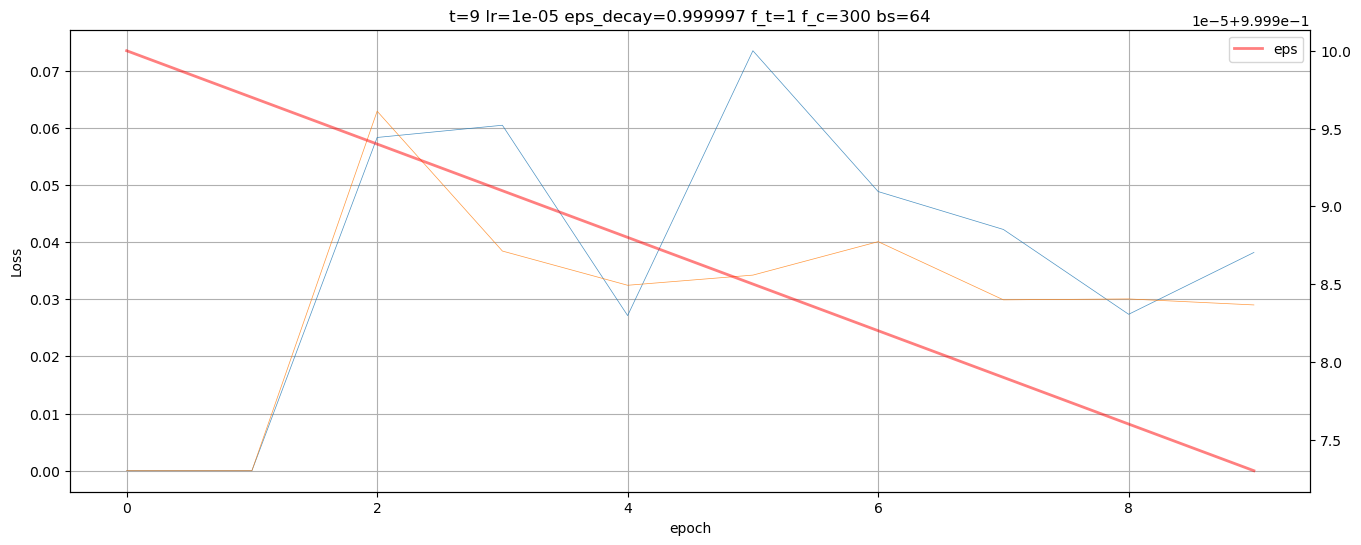

 19%|█▉        | 19/100 [00:09<00:36,  2.22it/s]

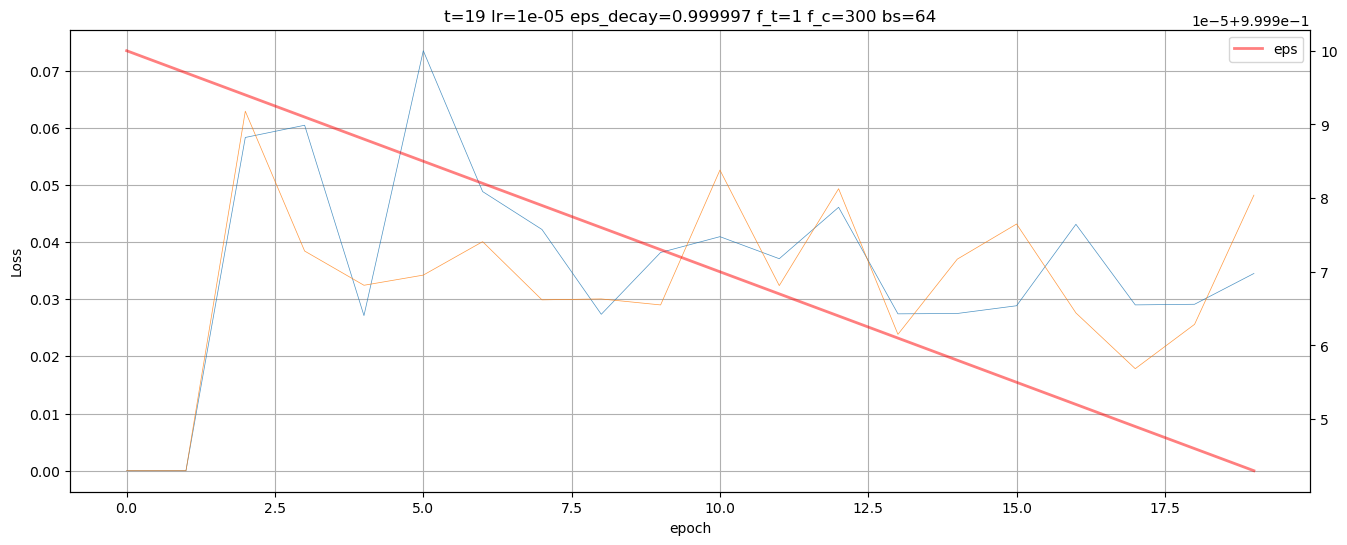

 29%|██▉       | 29/100 [00:15<00:36,  1.96it/s]

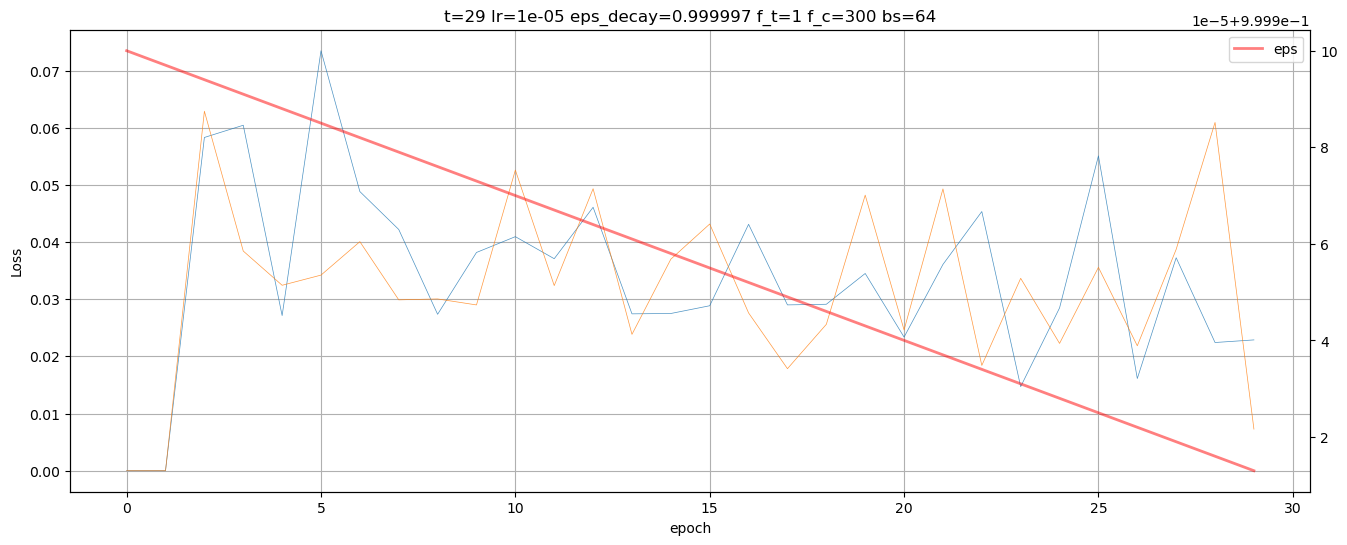

 39%|███▉      | 39/100 [00:21<00:30,  2.01it/s]

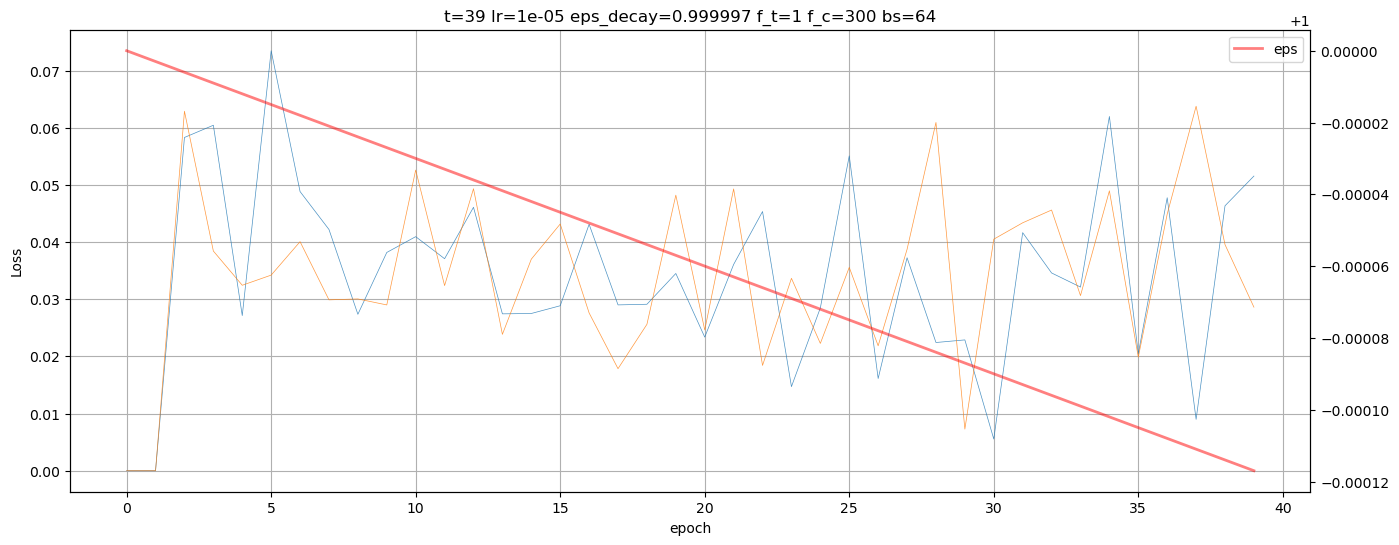

 49%|████▉     | 49/100 [00:26<00:23,  2.21it/s]

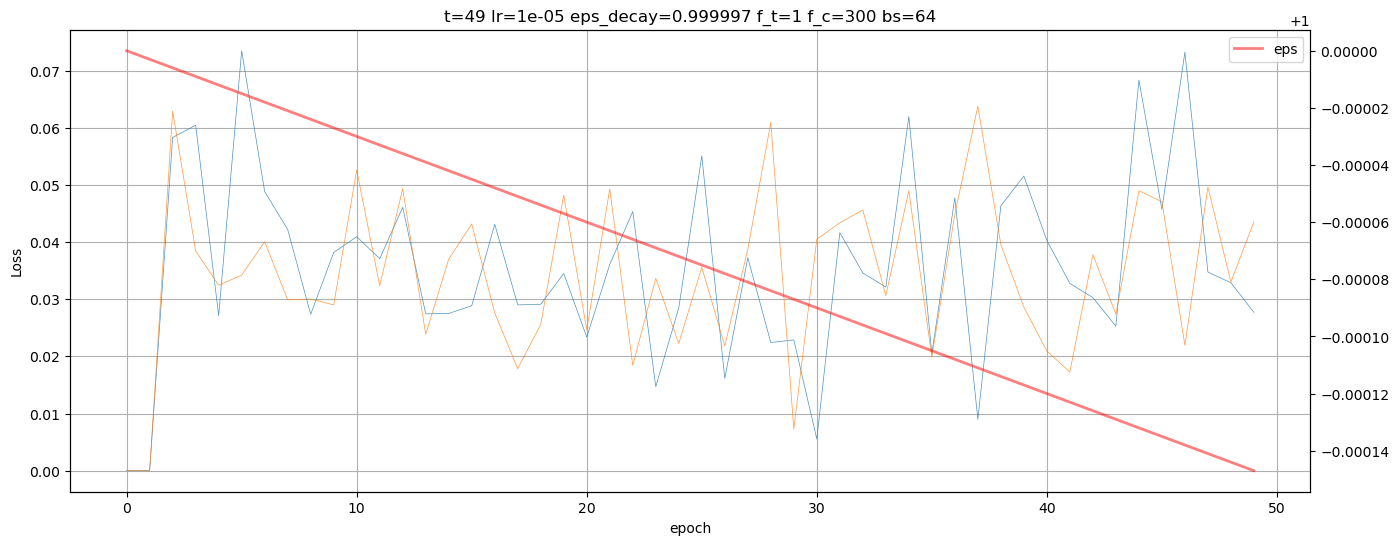

 59%|█████▉    | 59/100 [00:32<00:21,  1.89it/s]

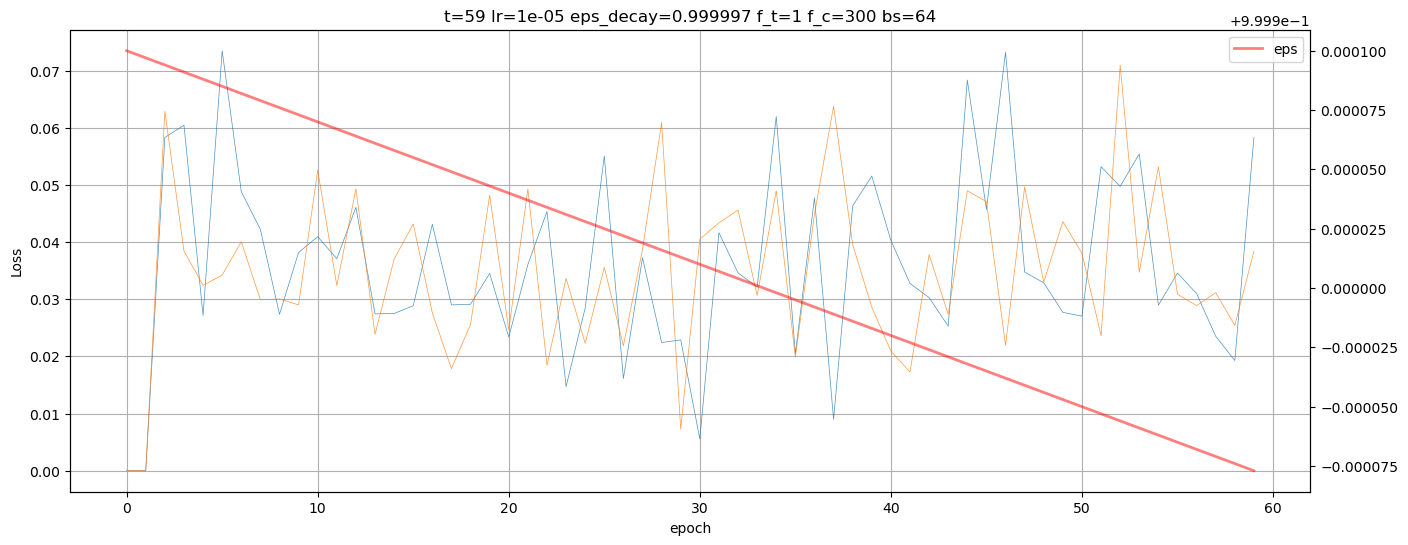

 69%|██████▉   | 69/100 [00:38<00:14,  2.20it/s]

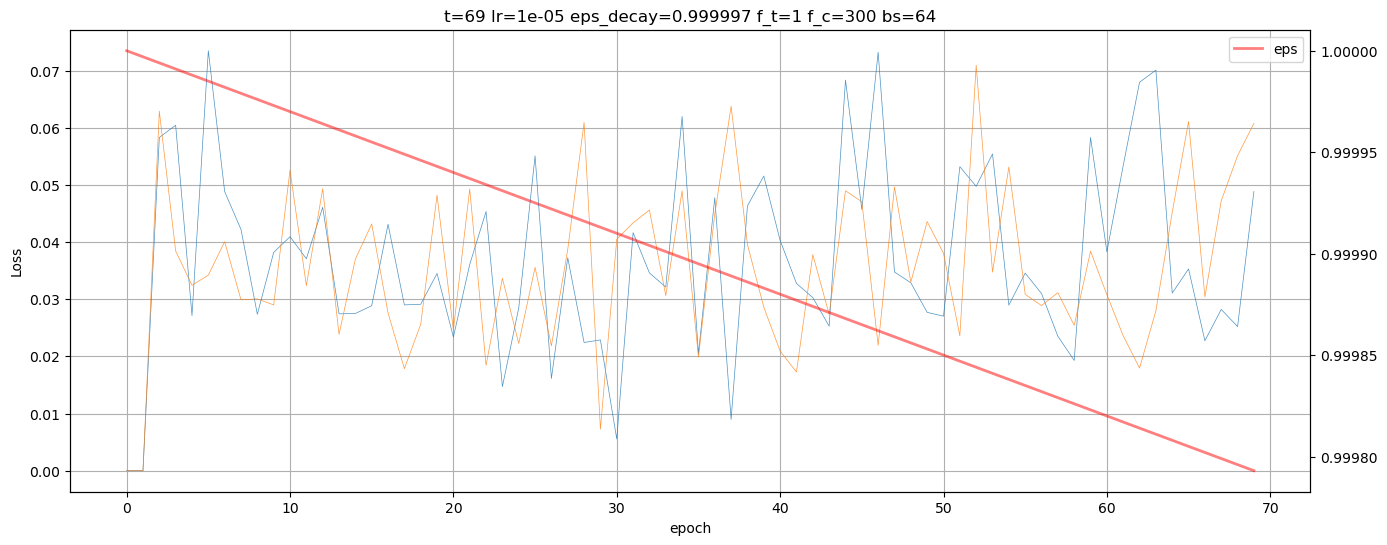

 79%|███████▉  | 79/100 [00:43<00:09,  2.26it/s]

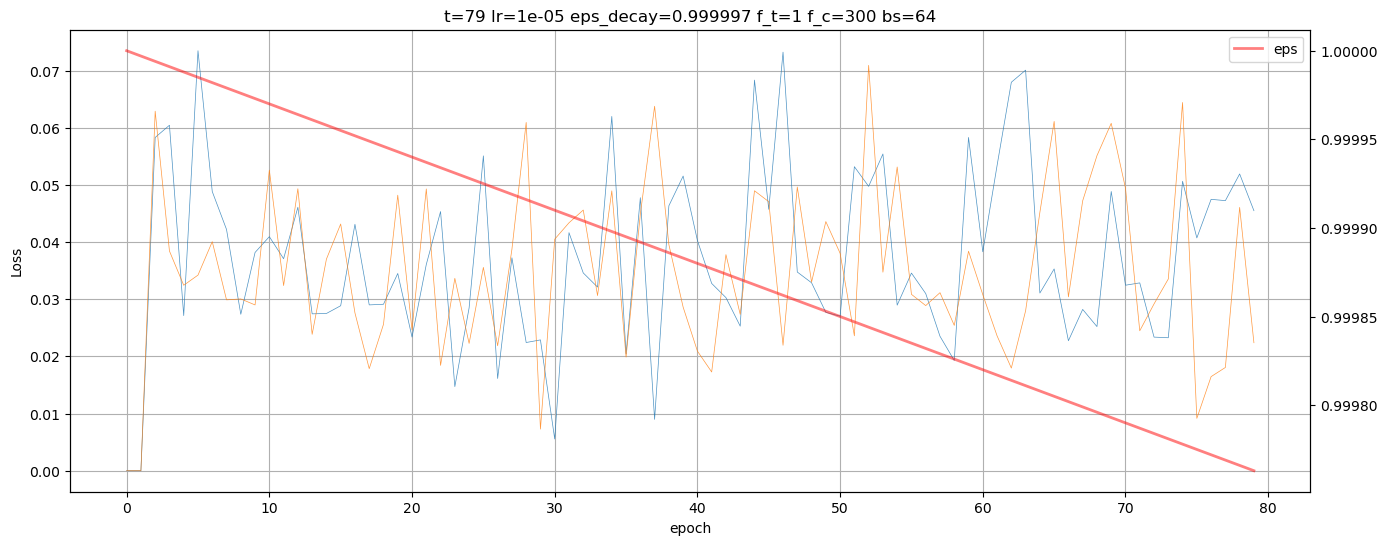

 86%|████████▌ | 86/100 [00:48<00:07,  1.76it/s]

In [15]:
from datetime import datetime
import itertools
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

from game import Game

losses = [[] for i in range(num_learning_agents)]
times = []
EPS = []
results = []
eval_times = []
eval_scores1 = [], []
eval_qval1 = []
eval_qval2  = []
eval_qval3 = []

for t in tqdm(range(epochs)):
    for pair in itertools.combinations(agents, 2):
        # makes sure players play on both sides
        pair = list(pair)
        random.shuffle(pair)
        Game.play_exp_game(pair)

    if not (t+1) % train_freq:
        times.append(t)
        EPS.append(eps)
        for i, agent in enumerate(agents):
            if isinstance(agent, LearningAgent):
                loss = agent.train_step(batch_size, gamma)
                losses[i].append(loss)

    if not (t+1) % target_update_freq:
        for agent in agents:
            if isinstance(agent, LearningAgent):
                agent.update_target_model()

    if not (t+1) % eval_freq:
        # eval_times.append(t)
        # # eval_scores1.append(play_eval_game(agent1, num_games=20))
        # q_val = get_action_qval(main_model, device=device)
        # eval_qval1.append(q_val[0])
        # eval_qval2.append(q_val[1])
        # eval_qval3.append(q_val[2])
        pass

    if not (t+1) % checkpoint_freq:
        stamp = datetime.now().strftime("%d%m%y-%H%M%S")
        for i, agent in enumerate(agents):
            if isinstance(agent, LearningAgent):   
                path = rf'logs/cp{(t+1)//checkpoint_freq}_agent{i}_{stamp}.pth'     
                torch.save(main_models[i], path)

        plt.figure(figsize=(16, 6))
        # plt.subplot(211)
        for i, agent in enumerate(agents):
            if isinstance(agent, LearningAgent):  
                plt.plot(times, losses[i], linewidth=0.5, alpha=0.8)
        plt.xlabel("epoch")
        plt.ylabel("Loss")
        plt.grid()
        ax2 = plt.twinx()
        ax2.plot(times, EPS, 'r-', label='eps', linewidth=2, alpha = 0.5)
        ax2.legend()
        plt.title(f't={t} lr={lr:.0e} eps_decay={eps_decay} f_t={train_freq} f_c={target_update_freq} bs={batch_size}')

        # plt.subplot(212)
        # plt.plot(eval_times, eval_qval1, 'o-', markersize=3, label=f'state 1')
        # plt.plot(eval_times, eval_qval2, 'o-', markersize=3, label=f'state 2')
        # plt.plot(eval_times, eval_qval3, 'o-', markersize=3, label=f'state 3')
        # plt.xlabel('time')
        # plt.ylabel('Q-val')
        # plt.legend()
        # plt.grid()
        plt.show()

    if eps > eps_min:
        eps *= eps_decay